In [3]:
from pulp import *
import numpy as np
from numpy import math
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [4]:
# locations of each sites
def generate_sites(num_customer_sites):
    # create the total number of sites
    sites = list(np.arange(0, num_customer_sites + 5))
    # self-driving time list
    sdtlist1 = []
    sdtlist2 = []

    # create distance matrix
    d_matrix = np.zeros((len(sites), len(sites)))

    # randomly generate the coordiantes of all sites
    np.random.seed(123)
    positions = dict((a, (np.random.rand() - .5, np.random.rand() - .5)) for a in sites)
    
    # org
    positions[0] = (0, 0)
    # pick up nodes
    # positions[1] = (-0.1, 0)
    # positions[2] = (0.2, 0)
    # positions[3] = (-0.2, 0)
    # positions[4] = (0.3, 0)
    # positions[5] = (0.4, 0)
    # positions[6] = (0.1, 0)
    # positions[7] = (-0.3, 0)
    # det
    positions[8] = (-0.4, 0)
    positions[9] = (-0.4, 0)
    positions[10] = (0.5,0)
    positions[11] = (0.5,0)

    # plot the coordiantes of all sites
    for s in positions:
        p = positions[s]
        plt.plot(p[0], p[1], 'o')
        plt.text(p[0] + .01, p[1], s, horizontalalignment='left', verticalalignment='center')
    plt.gca().axis('off');
    plt.show()

    # a function for computing distance between two points
    d = lambda p1, p2: np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # calculate all the paired distance
    for idx1, s1 in enumerate(positions):
        for idx2, s2 in enumerate(positions):
            if s1 != s2:
                d_matrix[idx1, idx2] = d(positions[s1], positions[s2])

    # calculate self-driving time
    for i in range(1,3):
        sdtlist1.append(d(positions[i], positions[8]))
    for j in range(3,8):
        sdtlist2.append(d(positions[j], positions[10]))

    return sites,d_matrix,positions,sdtlist1, sdtlist2

In [5]:
def get_tours(non_zero_edges,sites,t_matrix):
    
    def get_next_site(parent,vehicle):
        '''helper function to get the next edge'''
        edges = [e for e in non_zero_edges if e[0] == parent and e[2] == vehicle]
        # print (edges)
        # for e in edges:
        #     non_zero_edges.remove(e)
        return edges
    
    tours1 = get_next_site(0,1)
    tours2 = get_next_site(0,2)
    
    # get tours 1
    tours1 = [[e] for e in tours1]
    n = 1
    for t in tours1:
        while n < len(sites):
            if t[-1][1] == 10:
                break
            else:
                t.append(get_next_site(t[-1][1],1)[-1])
                n += 1
                
    # get tours 2
    tours2 = [[e] for e in tours2]
    m = 1
    for t1 in tours2:
        while m < len(sites):
            if t1[-1][1] == 11:
                break
            else:
                t1.append(get_next_site(t1[-1][1],2)[-1])
                m += 1

    # Print he optimal tours:
    for t in tours1:
        print(' -> '.join([ str(a) for a,b,c in t]))
    for t1 in tours2:
        print(' -> '.join([ str(a) for a,b,c in t1]))

    return tours1, tours2

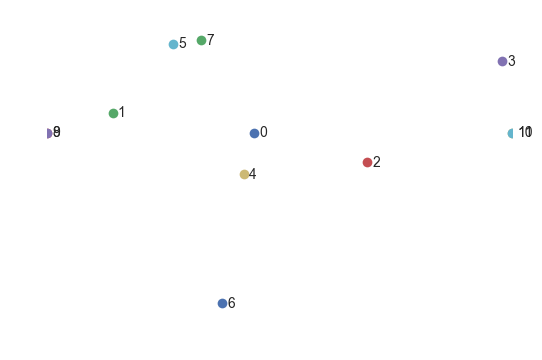

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

In [6]:
num_customer_sites = 7  # define the number of pickup nodes
capacity = 4
num_K = math.ceil(num_customer_sites/capacity)  # the number of cars
K = list(np.arange(1, num_K + 1))
staytime = 1
M = 9999
speed = 0.05
avgtime1 = 0
avgtime2 = 0
avgtime3 = 0
avgtime4 = 0
sdtime1 = []
sdtime2 = []

# geneate sites, distance matrix, self-driving distance
sites, d_matrix, positions,sdtlist1,sdtlist2 = generate_sites(num_customer_sites)

# calculate self-driving time
for a in range(0,len(sdtlist1)):
    sdtime1.append(sdtlist1[a]/speed)
for b in range(0, len(sdtlist2)):
    sdtime2.append(sdtlist2[b] / speed)

# standardize data
standardized_sdtime1 = StandardScaler().fit_transform(sdtime1)
standardized_sdtime2 = StandardScaler().fit_transform(sdtime2)
avg_d_matrix = d_matrix.mean()
std_d_matrix = d_matrix.std()
standardized_d_matrix = StandardScaler().fit_transform(d_matrix)
t_matrix = d_matrix/speed
avg_t_matrix = t_matrix.mean()
std_t_matrix = t_matrix.std()
standardized_t_matrix = StandardScaler().fit_transform(t_matrix)

#generate indices for distance matrix
X,Y,Z = np.meshgrid( np.arange(len(sites)), np.arange(len(sites)),np.arange(1,num_K+1))
x_matrix_coordinate_list = []
for coor in zip(X.flatten(),Y.flatten(),Z.flatten()):
    x_matrix_coordinate_list.append(coor)

#generate indices for start time
X1,Y1 = np.meshgrid( np.arange(len(sites)), np.arange(1,num_K+1))
start_time_coordinate_list = []
for coor1 in zip(X1.flatten(),Y1.flatten()):
    start_time_coordinate_list.append(coor1)

#generate indices for all rows and cols
X2,Y2 = np.meshgrid( np.arange(len(sites)), np.arange(len(sites)))
rc_coordinate_list = []
for coor2 in zip(X2.flatten(),Y2.flatten()):
    rc_coordinate_list.append(coor2)

In [7]:
#create the problme
prob=LpProblem("transpotation",LpMinimize)

# create decision variables
# dummy variable if site i is connected to site j in the tour
x = LpVariable.dicts('x', (sites,sites,K), 0, 1, LpBinary)
# start time variable at each node
s = LpVariable.dicts('s', (sites,K), 0, None , LpContinuous)
L = LpVariable.dicts('L', (sites, K), 0, None, LpContinuous)
u = LpVariable('u', 0, None ,LpContinuous)

# objective function
dist = sum([x[r][c][z] * standardized_d_matrix[r, c] for (r, c, z) in x_matrix_coordinate_list])
avgtime1 =  sum([s[8][1] - s[r][c] for (r,c) in start_time_coordinate_list if c == 1 and s[r][c] != 0 and r < 3 and r >0])
avgtime2 = sum([s[10][1] - s[r][c] for (r, c) in start_time_coordinate_list if c == 1 and s[r][c] != 0 and r < 8 and r >2])
avgtime3 =  sum([s[9][2] - s[r][c] for (r,c) in start_time_coordinate_list if c == 2 and s[r][c] != 0 and r < 3 and r >0])
avgtime4 = sum([s[11][2] - s[r][c] for (r, c) in start_time_coordinate_list if c == 2 and s[r][c] != 0 and r < 8 and r >2])
avgtime = (avgtime1+avgtime2+avgtime3+avgtime4)/num_customer_sites
# avgtime = sum(s[9][2]+s[11][2]+s[8][1]+s[10][1])

alpha = 0.5
beta = 0.5
gamma = 0.5
cost = lpSum(alpha * dist + beta * avgtime + gamma * u)
prob+=cost

In [8]:
#add constraints
# (1) the diagonal value of x matrix is 0
for (r, c, z) in x_matrix_coordinate_list:
    if r == c:
        prob += x[r][c][z] == 0

# (2) org can not go to des
for (r, c, z) in x_matrix_coordinate_list:
    if (c == 8 or c == 9 or c == 10 or c == 11)and (r == 0):
        prob += x[r][c][z] == 0
#
# (3) node 1-4 can not go to des2
for (r, c, z) in x_matrix_coordinate_list:
    if (r == 1 or r == 2 ) and (c == 10 or c == 11):
        prob += x[r][c][z]  == 0
#
# (4) des1 can not go to node 1 to node 4
for (r, c, z) in x_matrix_coordinate_list:
    if (r == 8 or r==9) and( c == 1 or c == 2 ):
        prob += x[r][c][z] == 0
#
# (5) des1 will not go to des1
for (r, c, z) in x_matrix_coordinate_list:
    if (r == 8 or r == 9) and (c == 8 or c == 9):
        prob += x[r][c][z]  == 0

# (6) des2 is the final visited ndde if is it not equal to 0
for (r, c, z) in x_matrix_coordinate_list:
    if (r == 10 or r == 11):
        prob += x[r][c][z]  == 0

# (9) des1 can not go to des22, des11 can not go to des2
for (r, c, z) in x_matrix_coordinate_list:
    if r == 8 and c == 11:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if r == 9 and c == 10:
        prob += x[r][c][z]  == 0

# vehicle 1 can not go to 9 and 11, vehicle 2 can not go to 8 and 10
for (r, c, z) in x_matrix_coordinate_list:
    if r == 9 and z == 1:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if c == 9 and z == 1:
        prob += x[r][c][z] == 0
for (r, c, z) in x_matrix_coordinate_list:
    if r == 8 and z == 2:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if c == 8 and z == 2:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if r == 11 and z == 1:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if c == 11 and z == 1:
        prob += x[r][c][z] == 0
for (r, c, z) in x_matrix_coordinate_list:
    if r == 10 and z == 2:
        prob += x[r][c][z]  == 0
for (r, c, z) in x_matrix_coordinate_list:
    if c == 10 and z == 2:
        prob += x[r][c][z]  == 0

# ############################################################################################################################
# ###########          papaer constraints      ###############################################################################
# ############################################################################################################################

# (8) node1-7 is visted only once by one vehicle -- 1&2
for i in range(1, 8):
    prob += lpSum([ x[r][c][z] for (r,c,z) in x_matrix_coordinate_list if r== i ]) == 1
    prob += lpSum([ x[r][c][z] for (r,c,z) in x_matrix_coordinate_list if c== i ]) == 1
#
# (10) des is not necessarily to be visited -- 1&2
for m in range(8,10):
    prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (r == m)]) <= 1
for l in range(8,12):
    prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (c == l)]) <= 1
# #

# (7) no node can go to orgin -- 3
for (r, c, z) in x_matrix_coordinate_list:
    if c == 0:
        prob += x[r][c][z]  == 0
#
# (11) only one pickup nodes is visited from origin for each vehicle -- 4
prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if
                r == 0 and z == 1 and (c == 1 or c == 2 or c == 3 or c == 4 or c == 5 or c == 6 or c == 7)]) == 1
prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if
                r == 0 and z == 2 and (c == 1 or c == 2 or c == 3 or c == 4 or c == 5 or c == 6 or c == 7)]) == 1

# (10) flow balance -- 6
for k in range(1,10):
    prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (r == k) and z == 1]) - lpSum(
        [x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (c == k) and z == 1]) == 0
    prob += lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (r == k) and z == 2]) - lpSum(
        [x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if (c == k) and z == 2]) == 0
    
# (13) start time is set correctly along the path -- 7
for (r, c, z) in x_matrix_coordinate_list:
    prob += s[c][z] - s[r][z] - standardized_t_matrix[r, c] + M * (1 - x[r][c][z]) >= staytime

# # (14) pick up all passengers to des1 before arriving des1
#        pick up all passengers to des2 before arriving des2  -- 8
for (r, z) in start_time_coordinate_list:
    if s[8][1] != 0 and r < 3 and r > 0 and z == 1:
        prob += s[8][1] - s[r][z] >= 0
    if s[10][1] != 0 and r < 8 and r > 2 and z == 1:
        prob += s[10][1] - s[r][z] >= 0
    if s[9][2] != 0 and r < 3 and r > 0 and z == 2:
        prob += s[9][2] - s[r][z] >= 0
    if s[11][2] != 0 and r < 8 and r > 2 and z == 2:
        prob += s[11][2] - s[r][z] >= 0
        
# the arrival of des1 is before des2 for each vehicle
if s[10][1] != 0:
    prob += s[10][1] - s[8][1] >= 0
if s[11][2] != 0:
    prob += s[11][2] - s[9][2] >= 0
#
# the start time is set correctly along the path -- 9
for j in range(1,len(sites)):
    prob += s[j][1] - M * (lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if c == j and z == 1])) <= 0
    prob += s[j][2] - M * (lpSum([x[r][c][z] for (r, c, z) in x_matrix_coordinate_list if c == j and z == 2])) <= 0
#
# the maximal difference between self-driving and shuttle time, u constraint -- 10
for r in range(1,3):
    if s[r][1] != 0 and s[8][1] != 0:
        prob += u - (s[8][1] - s[r][1]) + standardized_sdtime1[r - 1] >= 0
    if s[r][2] != 0 and s[9][2] != 0:
        prob += u - (s[9][2] - s[r][2]) + standardized_sdtime1[r - 1] >= 0
for z in range(3,8):
    if s[z][1] != 0 and s[10][1] != 0:
        prob += u - (s[10][1] - s[r][1]) + standardized_sdtime2[r - 3] >= 0
    if s[z][2] != 0 and s[11][2] != 0:
        prob += u - (s[11][2] - s[r][2]) + standardized_sdtime2[r - 3] >= 0

# capacity constraint -- 11
for (r, c, z) in x_matrix_coordinate_list:
    if c != 8 and c != 9 and c != 10 and c != 11:
        prob += L[r][z] - L[c][z] - M * (1 - x[r][c][z]) + 1 <= 0
        prob += L[r][z] - L[c][z] + M * (1 - x[r][c][z]) + 1 >= 0
    else:
        prob += L[r][z] - L[c][z] - M * (1 - x[r][c][z])  <= 0
        prob += L[r][z] - L[c][z] + M * (1 - x[r][c][z])  >= 0

# # capacity at each node should be not greater than vehicle capacity -- 12
for (r, c) in start_time_coordinate_list:
    prob += L[r][c] <= capacity

# the original capacity for each vehicle is 0 -- 13
L[0][1] = 0
L[0][2] = 0

############################################################################################################################
######################      end of constraints        ######################################################################
############################################################################################################################

In [9]:
# The problem data is written to an .lp file
# prob.writeLP("my_problem.lp")
# solve the problem
result = prob.solve()
print(LpStatus[prob.status])

# print solution
print(value(prob.objective))
for v in prob.variables():
    print(v.name, "=", v.varValue)

non_zero_edges = [ e for e in x_matrix_coordinate_list if value(x[e[0]][e[1]][e[2]]) != 0 ]
print("All non zero edges are : ")
print (non_zero_edges)

totaldist = []
totaltime1 = []
totaltime2 = []
starttime = []
tours1,tours2 = get_tours(non_zero_edges, sites,t_matrix)
# print("The arranged optimal route1 is : ")
# print(tours1[0])
# print("The arranged optimal route2 is : ")
# print(tours2[0])
for a, b,c in non_zero_edges:
    totaldist.append(d_matrix[a, b])
for c,d,e in tours1[0]:
    totaltime1.append(t_matrix[c,d])
for f,g,h in tours2[0]:
    totaltime2.append(t_matrix[f,g])
# for i in range(1,len(totaltime1)+1):
#     starttime.append(sum(totaltime1[0:i]))

print("The start time at each node is: ")
print(starttime)
print("The optimal distance is: ", sum(totaldist))
print("The optimal time is: ", sum(totaltime1)+sum(totaltime2))

Optimal
0.186594291036
L_0_1 = 0.0
L_0_2 = 0.0
L_10_1 = 3.0
L_10_2 = 0.0
L_11_1 = 0.0
L_11_2 = 4.0
L_1_1 = 0.0
L_1_2 = 2.0
L_2_1 = 0.0
L_2_2 = 1.0
L_3_1 = 3.0
L_3_2 = 0.0
L_4_1 = 1.0
L_4_2 = 0.0
L_5_1 = 0.0
L_5_2 = 3.0
L_6_1 = 2.0
L_6_2 = 0.0
L_7_1 = 0.0
L_7_2 = 4.0
L_8_1 = 0.0
L_8_2 = 0.0
L_9_1 = 0.0
L_9_2 = 2.0
s_0_1 = 0.0
s_0_2 = 0.0
s_10_1 = 2.0344739
s_10_2 = 0.0
s_11_1 = 0.0
s_11_2 = 3.2089598
s_1_1 = 0.0
s_1_2 = 1.5957406
s_2_1 = 0.0
s_2_2 = 0.14043898
s_3_1 = 2.0344739
s_3_2 = 0.0
s_4_1 = 0.0
s_4_2 = 0.0
s_5_1 = 0.0
s_5_2 = 2.3243303
s_6_1 = 0.01954454
s_6_2 = 0.0
s_7_1 = 0.0
s_7_2 = 1.7689613
s_8_1 = 0.0
s_8_2 = 0.0
s_9_1 = 0.0
s_9_2 = 1.5957406
u = 2.592781
x_0_0_1 = 0.0
x_0_0_2 = 0.0
x_0_10_1 = 0.0
x_0_10_2 = 0.0
x_0_11_1 = 0.0
x_0_11_2 = 0.0
x_0_1_1 = 0.0
x_0_1_2 = 0.0
x_0_2_1 = 0.0
x_0_2_2 = 1.0
x_0_3_1 = 0.0
x_0_3_2 = 0.0
x_0_4_1 = 1.0
x_0_4_2 = 0.0
x_0_5_1 = 0.0
x_0_5_2 = 0.0
x_0_6_1 = 0.0
x_0_6_2 = 0.0
x_0_7_1 = 0.0
x_0_7_2 = 0.0
x_0_8_1 = 0.0
x_0_8_2 = 0.0
x_0_9_1 = 0.